In [1]:
from sklearn import datasets
import numpy as np

In [8]:
iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [6]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [15]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [18]:
from sklearn.linear_model import Perceptron

In [20]:
ppn = Perceptron(eta0=0.01, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.01, random_state=1)

In [21]:
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d'%(y_test != y_pred).sum())

Misclassified examples: 2


In [24]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.956


In [25]:
print('Accuracy: %.3f' % ppn.score(X_test_std, y_test))

Accuracy: 0.956


# Visualization

In [27]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [73]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                   y=X[y == cl, 1],
                   alpha=0.8,
                   c=colors[idx],
                    marker=markers[idx],
                   label=cl,
                   edgecolor='black')
        
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1],
                   c='', edgecolor='black', alpha=1.0,
                   linewidth=1, marker='o',
                   s=100, label='test set')

<ipython-input-73-8fe0cfe69f90>:34: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0], X_test[:, 1],


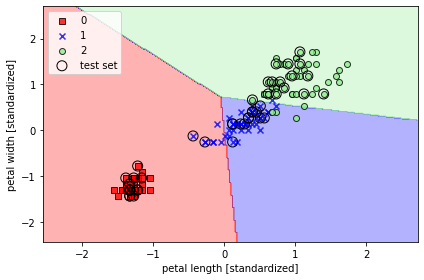

In [75]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std,
                     y=y_combined,
                     classifier=ppn,
                     test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

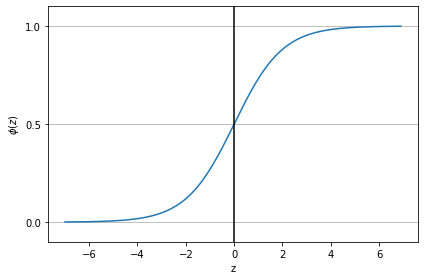

In [42]:
def sigmoid(z):
    return 1.0/ (1.0 + np.exp(-z))
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
# y axis ticks nad gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

# Loglikelihood function

<ipython-input-84-a8af997b221a>:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


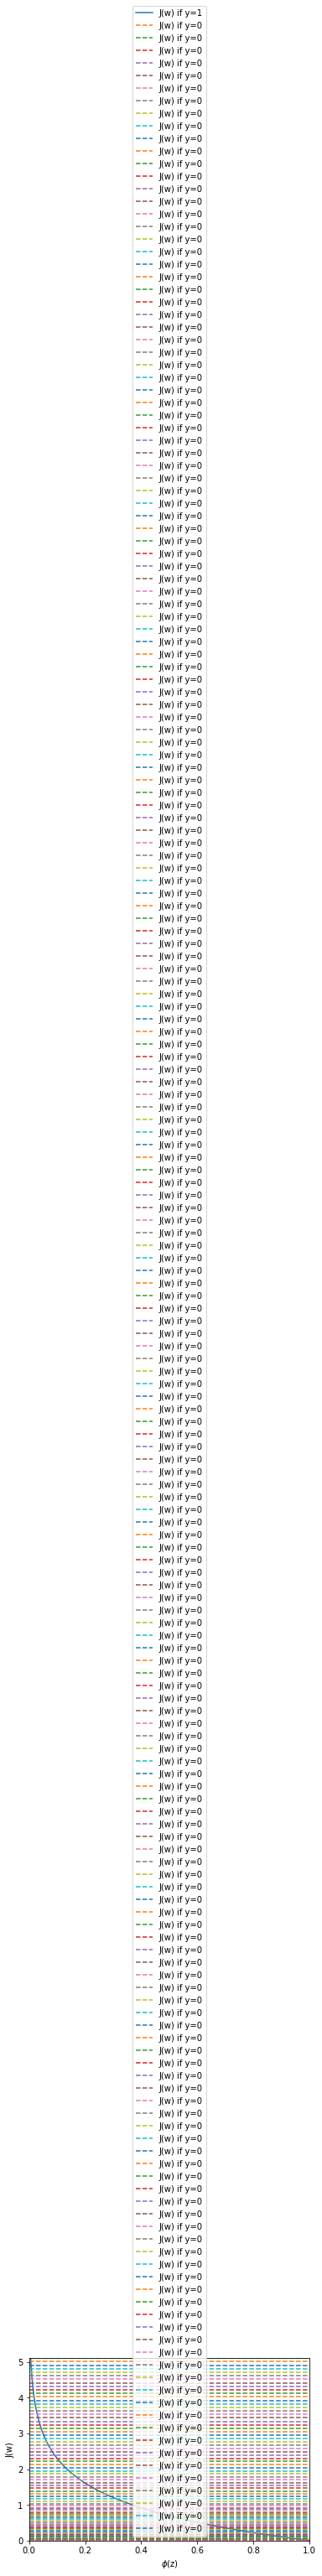

In [84]:
def cost_1(z):
    return - np.log(sigmoid(z))
def cost_0(z):
    return - np.log(1 - sigmoid(z))
z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')
c0 = [cost_0(z) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [79]:
class LogisticsRegressionGD(object):
    """Logistics Regression Classifier using gradient descent
    
    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator seed for random weight initialization.
        
    Attributes
    ----------
    w_ : 1d-array
        weights after fitting.
    cost_ : list
        Sum-of-squares cost function value in each epoch.
    
    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """Fit training data.
        
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples
            is the number of examples and 
            n_features is the number of features.
        y : array-like, shape = [n_examples]
            Target values.
            
        Returns
        -------
        self : object
        
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
                             size = 1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            
            # note that we compute logistic 'cost' now
            # instead of the sum of squared errors cost
            epsilon = 1e-5    
            cost = (-y.dot(np.log(output + epsilon)) - 
                   ((1 - y).dot(np.log(1 - output + epsilon))))
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute linear activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X))
                       >= 0.5, 1, 0)

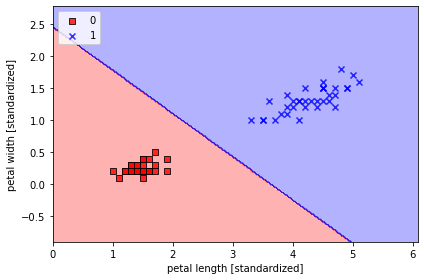

In [80]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticsRegressionGD(eta=0.05,
                          n_iter=1000,
                          random_state=1)
lrgd.fit(X_train_01_subset,
        y_train_01_subset)
plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                     classifier=lrgd)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-73-8fe0cfe69f90>:34: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0], X_test[:, 1],


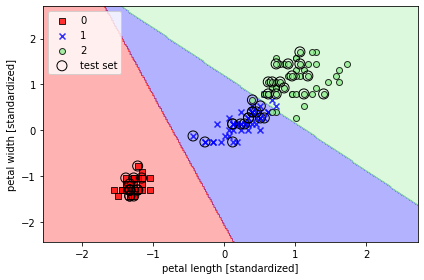

In [87]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1,
                        solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                     y_combined,
                     classifier=lr,
                     test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Regularization

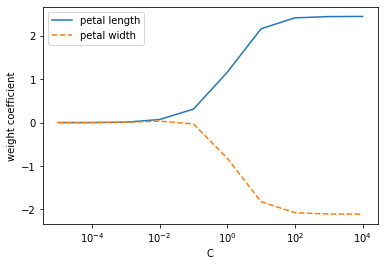

In [88]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1, solver='lbfgs', multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, weights[:, 0], label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

# Support Vector Machine

<ipython-input-73-8fe0cfe69f90>:34: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0], X_test[:, 1],


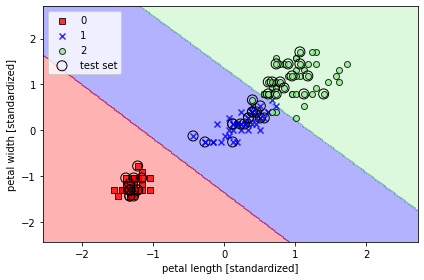

In [96]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                     y_combined,
                     classifier=svm,
                     test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Kernel SVM

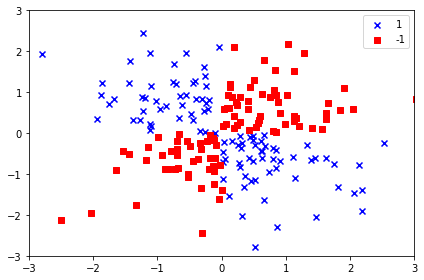

In [101]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                      X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor == 1, 0],
           X_xor[y_xor == 1, 1],
           c='b', marker='x',
           label='1')
plt.scatter(X_xor[y_xor == -1, 0],
           X_xor[y_xor == -1, 1],
           c='r', marker='s',
           label='-1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

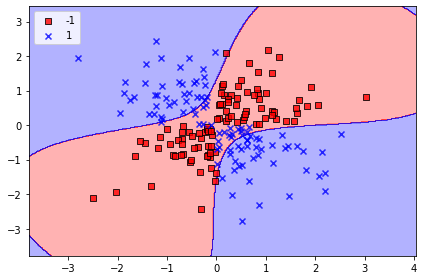

In [103]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.1, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Decision Tree

Text(0, 0.5, 'impurity index')

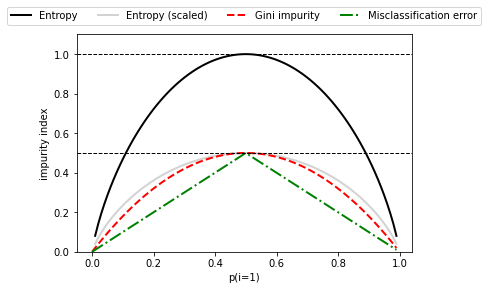

In [230]:
def gini(p):
    return (p)*(1- (p)) + (1 - p)*(1 - (1-p))
def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))
def error(p):
    return 1 - np.max([p, 1 - p])
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                        ['Entropy', 'Entropy (scaled)',
                        'Gini impurity',
                        'Misclassification error'],
                        ['-', '-', '--', '-.'],
                        ['black', 'lightgray',
                        'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab,
                  linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
         ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')

<ipython-input-73-8fe0cfe69f90>:34: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0], X_test[:, 1],


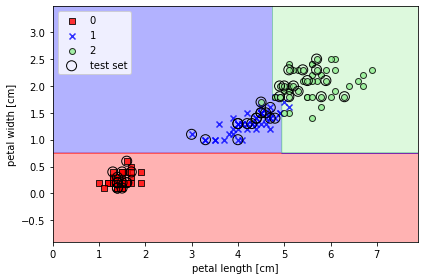

In [233]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='gini',
                                   max_depth=4,
                                   random_state=1)
tree_model.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined,
                     y_combined,
                     classifier=tree_model,
                     test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

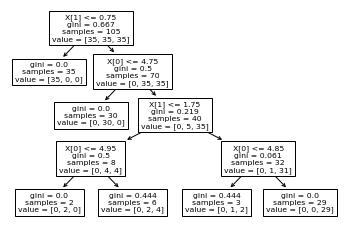

In [234]:
from sklearn import tree
tree.plot_tree(tree_model)
plt.show()

# Random forest

In [236]:
from sklearn.ensemble import RandomForestClassifier

<ipython-input-73-8fe0cfe69f90>:34: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0], X_test[:, 1],


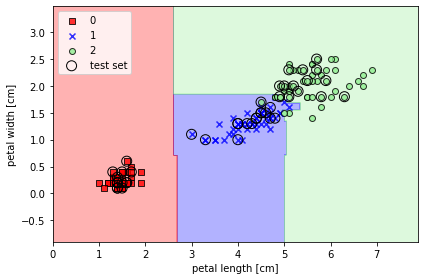

In [237]:
forest = RandomForestClassifier(criterion='gini',
                               n_estimators=25,
                               random_state=1,
                               n_jobs=2)
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined,
                     classifier=forest, test_idx=range(105,150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# KNN

In [240]:
from sklearn.neighbors import KNeighborsClassifier

<ipython-input-73-8fe0cfe69f90>:34: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0], X_test[:, 1],


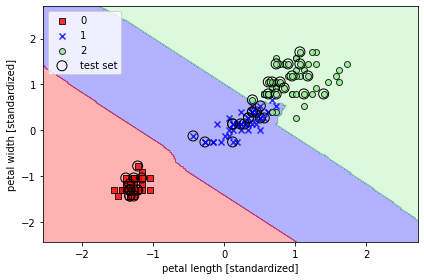

In [242]:
knn = KNeighborsClassifier(n_neighbors=5, p=5,
                          metric='minkowski')
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                     classifier=knn, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()